## From Amazon to Netflix, what makes a great recommendation?

### Capstone Project

### Bill Zhang

----------

### Introduction

Recommender system is one of the most popular topics in data science nowadays. Industry leaders in recommender system, such as Amazon and Netflix, have spent years R&D and benefit from it siginificantly. Taking Amazon for example, recommender system is credited for 35% of total revenues and 29% growth in sales. And for Netflix, up to 75% of content viewed comes from its recommender system and this system saves 1 billion marketing cost each year. 

*Source: https://sigmoidal.io/recommender-systems-recommendation-engine/*

Therefore, the potential and benefit of implementing a good recommender system is enourmos. For this capstone project, following commonly used models for recommender system will be used to see how to makes a good recommender system. 

- Popularity model
- Content-based model
- Collaborative model
- Hybrid model
- Convolutional Neural Network

### Data

**“Articles sharing and reading from CI&T DeskDrop”** from Kaggle

*Source: https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop*

#### Dataset: 

**The dataset contains two csv file. **

- **shared_articles.csv (df_article)**: Articles shared on the platform including content Id, author Id, title, description and language. 

- **users_interactions.csv (df_user)**: logs of all the interaction from registered uses including content id, user id and 5 different types of reaction (view, like, bookmarked, commented and follow) 

### Install Libraries

In order to run the model, following two extra libraries need to be installed 

**Wordcloud**

-pip install wordcloud

**Surprise**

-pip install scikit-surprise

---------

### Preprocessing

First load necessary libraries and data to see what clean up need to be done.

In [1]:
import numpy as np
import pandas as pd
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
## load data

df_article=pd.read_csv('shared_articles.csv')
df_user=pd.read_csv('users_interactions.csv')

### Article data

In [3]:
df_article.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


Check the shape and see if there is null value in df_article

In [5]:
print(df_article.shape)
df_article.isnull().sum()

(3122, 13)


timestamp             0
eventType             0
contentId             0
authorPersonId        0
authorSessionId       0
authorUserAgent    2442
authorRegion       2442
authorCountry      2442
contentType           0
url                   0
title                 0
text                  0
lang                  0
dtype: int64

Notice that for authorUserAgent, authorRegion and authorCountry, the number of null value has exceeded more than half of the data. Therefore, they are not very helpful to our models and we can drop them. 

In [6]:
df_article=df_article.drop(['authorUserAgent','authorRegion','authorCountry'], axis=1)

Also, there is a column named "eventType" and we count its unique values

In [7]:
df_article['eventType'].value_counts()

CONTENT SHARED     3047
CONTENT REMOVED      75
Name: eventType, dtype: int64

Here we only consider the articles are still available to our users

In [8]:
df_article=df_article[df_article['eventType']=='CONTENT SHARED']

We also count the unique value of 'lang'

In [231]:
df_article.groupby(['lang']).count()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,title,text
lang,,,,,,,
en,2211,2211,2211,2211,2211,2211,2211
es,2,2,2,2,2,2,2
ja,2,2,2,2,2,2,2
la,3,3,3,3,3,3,3
pt,829,829,829,829,829,829,829


For simplicity, we only consider the articles that are written in English

In [10]:
df_article=df_article[df_article['lang']=='en']

In [12]:
## check if there is null value after cleaning

df_article.isnull().sum()

timestamp          0
eventType          0
contentId          0
authorPersonId     0
authorSessionId    0
title              0
text               0
lang               0
dtype: int64

In [11]:
df_article.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


### User Data

In [13]:
df_user.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


Check the shape and see if there is null value in df_user

In [14]:
print(df_user.shape)
df_user.isnull().sum()

(72312, 8)


timestamp          0
eventType          0
contentId          0
personId           0
sessionId          0
userAgent      15394
userRegion     15405
userCountry    15394
dtype: int64

Here we simply drop 'userAgent','userRegion' and 'userCountry' since we cannot fill in the null value in this case. 

In [15]:
df_user=df_user.drop(['userAgent','userRegion','userCountry'], axis=1)

### Rating Matrix

In order to qualtify our user's interaction so that we can convert the prediction in classification problem, we give each type of interaction with articles a corresponding socre based on it distribution. For rating matrix, we only count once if there are more than one interaction for each type of interaction. Therefore, our rating for each article is range from 1 to 15 (1+2+3+4+5)

In [16]:
## interaction distribution

df_user['eventType'].value_counts()

VIEW               61086
LIKE                5745
BOOKMARK            2463
COMMENT CREATED     1611
FOLLOW              1407
Name: eventType, dtype: int64

In [17]:
## give each type of interaction above a score

score={'VIEW': 1,
       'LIKE': 2,
       'BOOKMARK': 3,
       'COMMENT CREATED': 4,
       'FOLLOW': 5
      }

In [19]:
## apply this rating matrix for the data

df_user['score']=df_user['eventType'].apply(lambda x: score[x])

df_user.head()

,timestamp,eventType,contentId,personId,sessionId,score
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,1
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,1
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,1
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,5
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,1


### Feature engineering 

For the baseline model, we only consider following features for each dataset. New features will be created when we go through each model as we needed. 

- contentId 
- personId (user Id)
- score (based on rating matrix)
- title (article)
- text (article)

### Combined table

After cleaning, combine article and user data into one dataframe with columns above

In [23]:
## Create a copy of user data
df_joined=df_user.copy()

## extract contentId, personId and score from user dataframe 
df_joined=df_joined[['contentId', 'personId', 'score']]

## merge user and article dataframe
df_joined=df_joined.merge(df_article, on='contentId')

## drop unnecessary columns 
df_combined=df_joined.drop(['timestamp', 'eventType', 'authorPersonId', 'authorSessionId', 'lang'], axis=1)

**Notice if users have the same intereaction more than once for certain article, we only count it once**

In [24]:
df_combined.drop_duplicates(inplace=True)

print(df_combined.shape)
df_combined.head()

(32623, 5)


,contentId,personId,score,title,text
0,-3499919498720038879,-8845298781299428018,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...
2,-3499919498720038879,-108842214936804958,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...
3,-3499919498720038879,-1443636648652872475,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...
6,-3499919498720038879,-8020832670974472349,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...
8,-3499919498720038879,-9009798162809551896,2,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...


-------

### Popularity Model

Popularity model is the most commonly used model for basic recommender system, which simply recommend the most popular items based on average rating from users. 

We will use popularity model as the baseline model and see how it performs 

Notice each user can have multiple interactions with certain article, therefore we use the sum of scores to represent the score that user give to certain article

In [38]:
## create a new dataframe for popularity model called df_score
## sum of the score
df_score=df_combined.groupby(['personId', 'contentId', 'title', 'text']).sum().reset_index()

## average score for each article
df_score=df_score.groupby(['contentId', 'title', 'text']).mean().sort_values('score',ascending=False)
df_score=df_score.drop('personId', axis=1)
df_score=df_score.reset_index()

df_score.head(10)

,contentId,title,text,score
0,6847460841437230342,Indian outsourcing specialists must reboot the...,"COMPUTERS slow as they age, and before long mu...",11.333333
1,-4262964715347041233,Corporate Intrapreneur Summit,"The 2016 Corporate Intrapreneur Summit, produc...",10.666667
2,6800965548226529308,Sponsored: Five reasons why retailers should o...,Unsupported browser For a better experience pl...,10.000000
3,-340541651592032197,Relating a Problem Definition to IoT Architect...,"Lets face it, the largest function within IoT ...",10.000000
4,49177526672934036,After a year of using NodeJS in production,"This is a follow-up to my original ""Why I'm sw...",10.000000
5,5929055844564382383,Digital Tool as Strategic Enabler for Banking ...,"By Brian Pallas , founder and CEO of Opportuni...",10.000000
6,3116298625885250927,ESA says doomed Mars lander succumbed to bad a...,One second of faulty data led to the destructi...,10.000000
7,-2402157201203242566,Number26 raises another $40 million for its vi...,Berlin-based startup Number26 just raised a $4...,10.000000
8,-7568926158048616650,Adobe CQ/Adobe AEM,Use Case: We often come across situation where...,9.000000
9,-3351652027149912881,Feather: A Fast On-Disk Format for Data Frames...,"Wes McKinney, Software Engineer, Cloudera Hadl...",8.600000


#### The articles above are the top 10 commendation based on the average score and we can use Wordcloud to visualize the key words. 

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

## use CountVectorizer to preprocess the title of articles
title=df_score.title

vect = CountVectorizer(stop_words='english', ngram_range=(1,3)).fit(title)

In [42]:
## convert it into list before feed into wordcloud
words = vect.get_feature_names()
words= ''.join(words)

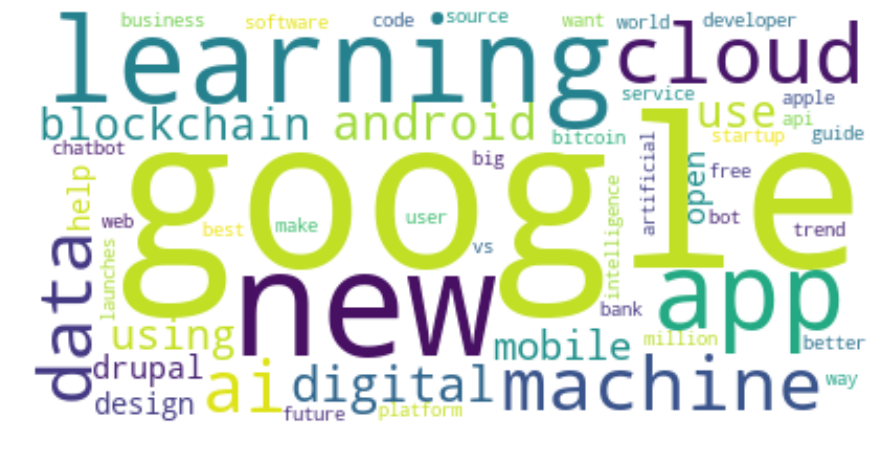

In [43]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white").generate(words)
plt.figure(figsize=(15,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**From wordcloud we can see that most users are very into technology. However, popularity model is not personalized. It can easily run into the problem when user is not interested in technology and its recommendation make no sense to this type of users**

-------

## Content-based model

In order to personalize the recommendation, we introduce the content-based model, which identifies similar articles. When user read one article, the model will recommend the articles that are most similar to the one that user read based on its algorithm. 

**Here we use pairwise cosine similarity of content of articles to determine how similar two articles are.**

In [44]:
## define tokenizer function

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import nltk
stemmer = nltk.stem.PorterStemmer()

def my_tokenizer(sentence):

    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    for word in listofwords:
        # Remove stopwords
        if word in ENGLISH_STOP_WORDS: continue
        # Stem words
        stemmed_word = stemmer.stem(word)
        for punctuation_mark in string.punctuation:
            # Remove punctuation and set to lower case
            stemmed_word = stemmed_word.replace(punctuation_mark, '').lower()
        listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [45]:
## use TfidfVectorizer for preprocessing the content of articles

from sklearn.feature_extraction.text import TfidfVectorizer

content=df_score.text

tfidf = TfidfVectorizer(stop_words = "english", ngram_range=(1,3), tokenizer=my_tokenizer)
tfidf.fit(content)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function my_tokenizer at 0x111bb99d8>, use_idf=True,
        vocabulary=None)

In [46]:
## transform the data 

text=tfidf.transform(content)
text.shape

(2149, 1839220)

In [47]:
## calculate cosine similarity

from sklearn.metrics.pairwise import cosine_similarity

similarity=cosine_similarity(text, text)

(2149, 2149)

In [49]:
## put cosine similarity matrix into dataframe

df_similarity=pd.DataFrame(similarity)

df_similarity['title']=df_score['title']
df_similarity=df_similarity.set_index('title')

df_similarity.head()

,0,1,2,3,4,5,6,7,8,9,...,2139,2140,2141,2142,2143,2144,2145,2146,2147,2148
title,,,,,,,,,,,,,,,,,,,,,
Indian outsourcing specialists must reboot their strategies,1.000000,0.003231,0.002119,0.000951,0.009794,0.025198,0.008240,0.015765,0.004186,0.004474,...,0.021500,0.007055,0.007313,0.003513,0.010953,0.003897,0.004982,0.004809,0.011234,0.006200
Corporate Intrapreneur Summit,0.003231,1.000000,0.002876,0.000000,0.001348,0.008200,0.001585,0.002591,0.000137,0.001458,...,0.004843,0.002362,0.006036,0.001455,0.004290,0.002050,0.001632,0.001530,0.003265,0.003406
Sponsored: Five reasons why retailers should opt for digital receipts,0.002119,0.002876,1.000000,0.000000,0.004526,0.003966,0.000705,0.001110,0.002981,0.001675,...,0.003859,0.001299,0.001888,0.000000,0.001722,0.002148,0.002487,0.001159,0.026774,0.000215
Relating a Problem Definition to IoT Architecture | Intel® Software,0.000951,0.000000,0.000000,1.000000,0.004332,0.005112,0.001647,0.000442,0.000562,0.000929,...,0.003625,0.000000,0.001442,0.000000,0.002249,0.005849,0.001545,0.000622,0.002826,0.002835
After a year of using NodeJS in production,0.009794,0.001348,0.004526,0.004332,1.000000,0.008270,0.007353,0.007706,0.020418,0.025951,...,0.018388,0.005352,0.006470,0.002540,0.013572,0.008977,0.008152,0.004811,0.010008,0.010544


#### Define a function to return 10 most similar articles

In [54]:
def return_article(title):
    number=df_score[df_score['title']==title].index.values
    return df_similarity.iloc[:, number].sort_values(number[0],ascending=False).head(11)

In [55]:
## return recommendation for article 'Corporate Intrapreneur Summit'

return_article('Corporate Intrapreneur Summit')

,1
title,
Corporate Intrapreneur Summit,1.000000
"[Free Online Course] Sit Less, Get Active - The University of Edinburgh | Coursera",0.035416
Building A Better Workforce: 5 Talent Trends Worth Watching,0.034872
Learning at the speed of business,0.033852
Acquia Engage Awards Finalists Announced,0.028541
5 reasons your employees aren't sharing their knowledge,0.021419
Facebook wants to change the way Australians use mobile banking,0.020454
Research: Why Best Practices Don't Translate Across Cultures,0.019319
The gig economy as a driver of innovation,0.018890


The first item in the table is the article user read and it has cosine similarity to itself equal to 1. The rest is top 10 recommendation based on cosine simialrity. Although the cosine similarity of recommended articile is not very high, it makes sense because we fit all the content of articles into the model. 

Now we have content based model that works better than simple popularity model, which recommend most similar articles. However, this model does not catch whether user like or dislike the article. Think about the situation that you accidently open a Youtube video you dislike and Youtube keeps recommend similar videos. This is exactly what happens to content based model.

--------

## Collaborative Model

In order to catch how much user like the articles, we introduce collaborative model to find the pattern of what articles user read and score they give. Based on this pattern, collaborative model will identify the most similar users and recommend the articles based on what they read.

For collaborative model, we will use a python scikit called 'Surprise' to building and analyzing recommender systems.

For more information about Surprise, check its Github page https://github.com/NicolasHug/Surprise

In [56]:
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate

In [57]:
## we use combined dataframe for collaborative model

df_combined.head()

,contentId,personId,score,title,text
0,-3499919498720038879,-8845298781299428018,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...
2,-3499919498720038879,-108842214936804958,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...
3,-3499919498720038879,-1443636648652872475,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...
6,-3499919498720038879,-8020832670974472349,1,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...
8,-3499919498720038879,-9009798162809551896,2,Hiri wants to fix the workplace email problem,Hiri is the latest startup trying to fix email...


In [59]:
## create a new dataframe and calculate the sum of all interaction of the users for each article

df_svd=df_combined.groupby(['personId', 'contentId', 'title', 'text']).sum().reset_index()
print(df_svd.shape)
df_svd.sort_values('score', ascending=False).head(10)

(26193, 5)


,personId,contentId,title,text,score
19664,3813842765808990208,-548976469460064550,Using Honcho to Create a Multi-Process Docker ...,A common misconception is that Docker is only ...,15
12860,-108842214936804958,-6467708104873171151,5 reasons your employees aren't sharing their ...,I rarely hear someone say ... WOW! We have so ...,15
25138,8437083040455072898,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,"Ray Kurzweil, the author, inventor, computer s...",15
9516,-1799631734242668035,6015995473246774717,The need to lead in data and analytics,"In a new survey, executives say senior-leader ...",15
5819,-4165818767652094649,-5997769775112032630,How bot-to-bot could soon replace APIs,By now it's clear that bots will cause a major...,15
16694,2416280733544962613,5930806521893160184,Five things to include in your digital transfo...,"In 2011, Disney World was facing declining cus...",15
17763,3217014177234377440,-5784228041033890044,[E-learning] Design Thinking for Innovation - ...,About this Course Today innovation is everyone...,15
11241,-1032019229384696495,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,A hidden source of friction is slowing your co...,15
11764,-1032019229384696495,8890720798209849691,Top 10 Intranet Trends of 2016,"Summary: Hero images, carousels, fat footers, ...",15
5343,-4627026983118548639,-5002383425685129595,Changing change management,Research tells us that most change efforts fai...,15


**To compare similar users based on interaction pattern, we use singular value decomposition (SVD) method, which is a factorization of a real or complex matrix.**

In [60]:
## import svd
svd=SVD()

## set up reader for rating range
reader = Reader(rating_scale=(1, 15))

## load data from dataframe
data = Dataset.load_from_df(df_svd[['personId', 'contentId', 'score']], reader)

## 5 fold cross validation measuring in Root mean squared error (RMSE) and Mean Absolute Error (MAE)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     1.0465  1.0701  1.0301  1.0713  1.0209  1.0478  0.0205  
RMSE (testset)    1.8719  1.9109  1.7939  1.9354  1.8359  1.8696  0.0508  
Fit time          1.83    1.45    1.51    1.50    1.48    1.55    0.14    
Test time         0.10    0.06    0.06    0.05    0.40    0.13    0.14    


{'fit_time': (1.828010082244873,
  1.4509170055389404,
  1.5108709335327148,
  1.498999834060669,
  1.4803252220153809),
 'test_mae': array([1.0464602 , 1.07014105, 1.0301041 , 1.07129259, 1.02086808]),
 'test_rmse': array([1.87193951, 1.91087122, 1.79390145, 1.93538651, 1.83589692]),
 'test_time': (0.09617996215820312,
  0.05749797821044922,
  0.06062793731689453,
  0.05304908752441406,
  0.4044039249420166)}

Sicne both MAE and RMSE are measuring the error in unit of variable, the result is relatively good given the rating range is between 1 to 15. 

We can use build in function to see the prediction for specific user and aritcile

In [61]:
## pick a user
df_svd[df_svd['personId']==-709287718034731589].head()

,personId,contentId,title,text,score
11892,-709287718034731589,-9189659052158407108,Eddy Cue and Craig Federighi Open Up About Lea...,Fast Company : Let's start talking about Maps....,1
11893,-709287718034731589,-9055044275358686874,Accept questions from your audience when prese...,Any skilled presenter knows that an interactiv...,3
11894,-709287718034731589,-9050450867630628092,Apple's secret strategy: Underpromise and over...,Why the critics are wrong who think Apple's lo...,1
11895,-709287718034731589,-9045753673721269477,BIG BRAND REDEMPTION | New free Trend Briefing...,The idea that all big brands are causing massi...,10
11896,-709287718034731589,-9002191823887486987,Is the Chatbot Trend One Big Misunderstanding?,Is the Chatbot Trend One Big Misunderstanding?...,3


In [62]:
## user id
uid = -709287718034731589

## article id
iid = -9055044275358686874

## get a prediction for it
pred=svd.predict(uid, iid, r_ui=3, verbose=True)

user: -709287718034731589 item: -9055044275358686874 r_ui = 3.00   est = 2.92   {'was_impossible': False}


r_ui here refers to the actual rating user gives to this article and est refers to the prediction. 

It seems like collaborative model works really well in terms of prediction. Next, we split the dataset for specific user where train set is all other users plus half articles of that specific user and test set is the other half articles of that specific user. 

In [77]:
## random select a user
random_select=df_svd['personId'].sample(n=1, random_state=9)

## select its data 
random_select=random_select.tolist()
df_sample=df_svd[df_svd['personId']==random_select].sort_values('score', ascending=False)
df_sample.head()

,personId,contentId,title,text,score
722,-8853658195208337106,-5879360586463363298,Introducing LambCI - a serverless build system,Introducing LambCI - a serverless build system...,10
782,-8853658195208337106,7506614456429888492,Assessing Salesforce's platform and ecosystem ...,Coming out of of the crush and excitement of D...,10
732,-8853658195208337106,-3780822597455574960,Top Programming Languages Trends: The Rise of ...,Illustration: Grzegorz Knec/Alamy Now that IEE...,10
751,-8853658195208337106,-14569272361926584,Java 8 Streams - A Deeper Approach About Perfo...,Introduction Java 8 was released almost three ...,10
730,-8853658195208337106,-4132331404553626868,Gartner Reprint,Gartner redesigned the Magic Quadrant for BI a...,10


In [79]:
## split train and test with test ratio equal to 0.2
sample=df_sample.sample(frac=0.2, random_state=2)
sample_list=sample.index.tolist()
df_notsample=df_svd.copy()

## build train data by dropping test data from the whole dataframe
df_notsample.drop(sample_list, inplace=True)

In [80]:
## set up reader 
reader = Reader(rating_scale=(1, 15))

## load train data
train_data = Dataset.load_from_df(df_notsample[['personId', 'contentId', 'score']], reader)

## load test data
test_data = Dataset.load_from_df(sample[['personId', 'contentId', 'score']], reader)

In [81]:
## build trainset
trainset = train_data.build_full_trainset()

## build testset
testset= test_data.build_full_trainset()
testset=testset.build_testset()

In [82]:
## load SVD
svd=SVD()

## fit trainset
svd.fit(trainset)

## predict testset 
sample_prediction=svd.test(testset)

## convert prediction into dataframe and sort by value
df_sample_prediction=pd.DataFrame(sample_prediction)
df_sample_prediction.sort_values('est', ascending=False)

,uid,iid,r_ui,est,details
7,-8853658195208337106,-1876558460087500339,1.0,3.500457,{'was_impossible': False}
2,-8853658195208337106,8483892789913825147,1.0,2.823233,{'was_impossible': False}
14,-8853658195208337106,-3678789633202302491,1.0,2.553679,{'was_impossible': False}
15,-8853658195208337106,31349081826574004,1.0,2.392274,{'was_impossible': False}
13,-8853658195208337106,-3058031327323357308,3.0,2.362585,{'was_impossible': False}
1,-8853658195208337106,8115033558441775155,1.0,2.305497,{'was_impossible': False}
3,-8853658195208337106,-8954346068661072425,1.0,2.256886,{'was_impossible': False}
8,-8853658195208337106,428486625959995206,1.0,1.994041,{'was_impossible': False}
9,-8853658195208337106,-1022885988494278200,3.0,1.925689,{'was_impossible': False}
11,-8853658195208337106,6062146090334604102,1.0,1.762617,{'was_impossible': False}


The prediction above is quite different from its actual rating. This is because SVD used regression rather than claasification in this case and our range is from 1 to 15, which makes the model even more complex than normal model. 

Another cause is cold start problem of collaborative model when there is not enough information about the user to make prediction. 

Althouhg the prediction for score of SVD is not very accurate for individual user, we can use alternative evaluation method to see how accurate our model is. For recommender system, we care about the rank more than predicted score. Therefore, we can use precision and recall at K to measure how accurate our recommendation in terms of ranking. 

### Precision and Recall @ k function from Surprise Package FAQ

Precision at k is the proportion of recommended items in the top-k set that are relevant

Recall at k is the proportion of relevant items found in the top-k recommendations

Here the relevant refers to the minimum score of our recommendation. For our model, we use threshold score equal to 3.

For more information. please check https://surprise.readthedocs.io/en/stable/FAQ.html

In [83]:
from collections import defaultdict

## define a function to calculate precision and recall
def precision_recall_at_k(predictions, k=5, threshold=3):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [86]:
## train test split 
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.2)

## fit trainset
svd.fit(trainset)

## prediction
predictions = svd.test(testset)

## load precision and recall function
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3)

## Precision and recall of averaged over all users
print('precisions: ', sum(prec for prec in precisions.values()) / len(precisions))
print('recalls: ', sum(rec for rec in recalls.values()) / len(recalls))

precisions:  0.938424543946932
recalls:  0.689841482906078


For collaborative model, we have 93.8% precision at 5, which is 93.8% of recommended items in the top 5 that are relevant. 

Recall at 5 is 69% of relevant items found in the top 5 recommendations. 


Therefore, when there is enough information about user, collaborative model is relatively accurate in terms of ranking of recommended articles. 

--------

## Hybrid Model

For hybrid model, we simple combine the features of content based model and collaborative model. Specifically, we use cosine similarity in content based model to replace the threshold of rating in collaborative model, then sort it based on the rank of collaborative model. 

In [91]:
def hybrid_model(user, title):
    '''Recommend unseen article based on cosine simialrity(content based) and 
    rank the top 10 based on SVD predicted socre(collaborative based)'''
    
    ## get the content ID of particular article
    number=df_score[df_score['title']==title].index.values
    
    ## get its cosine similarity with all article, create a data frame for it
    df_hybrid=df_similarity.iloc[:, number].reset_index()
    df_hybrid['contentId']=df_score['contentId']
    df_hybrid.columns=['title', 'similarity', 'contentId']
    
    ## sort the cosine similarity and get the top 20 (21 including the cosine similarity of itself)
    df_hybrid=df_hybrid.sort_values('similarity',ascending=False).head(21)
    
    ## save the content ID of top 20 into a list
    content=df_hybrid['contentId'].tolist()
    
    ## take out article user already view 
    viewed_list=df_svd[df_svd['personId']==user].contentId.values.tolist()
    content_list=list(set(content)-set(viewed_list))
    
    ## get the SVD predicted score from collaborative model
    predict=[]
    for i in content_list:
        result=svd.predict(user, i, verbose=False)
        predict.append(result)
    
    ## save the result into a data frame
    df_predict=pd.DataFrame(predict, columns=('personId', 'contentId', 'r_ui', 'predict', 'detail'))
    df_predict.drop(['r_ui', 'detail', 'personId'], axis=1, inplace=True)
    
    ## merge cosine similarity data frame and predicted score data frame
    df_hybrid=pd.merge(df_hybrid, df_predict, how='left', left_on='contentId', right_on='contentId')
    
    ## rank the recommendation result based on predicted score
    df_hybrid=df_hybrid.sort_values('predict', ascending=False)
    
    ## drop out input article (cosine similarity equal to 1)
    df_hybrid.drop(0, inplace=True)
       
    ## return top 10 recommendation
    return df_hybrid.head(10)

In [92]:
## test hybrid model with specific user and article

hybrid_model(6999578934585823267, "Deep Learning for Chatbots, Part 1 - Introduction")

,title,similarity,contentId,predict
5,2016 will be the year of conversational commer...,0.087048,5350829677696205474,1.803845
20,When will AI and NLP actually turn Siri into y...,0.057654,-2516726696296387544,1.763279
9,My Top 9 Favorite Python Deep Learning Librari...,0.066419,784265334245910688,1.556536
11,Approaching (Almost) Any Machine Learning Problem,0.064039,8381798621267347902,1.442310
17,Introducing DeepText: Facebook's text understa...,0.059672,1118048247334038458,1.436432
4,Chat Smarter with Allo,0.091583,-6858665134018491791,1.392167
14,Google Is About to Supercharge Its TensorFlow ...,0.060788,3564394485543941353,1.388065
19,Why 2016 is shaping up to be the Year of the Bot,0.058251,1433393829724383645,1.356656
8,Baidu Research grills AI models on deep learning,0.068620,-6570327055377820618,1.297996
18,"How Google is Remaking Itself as a ""Machine Le...",0.058868,5250363310227021277,1.279585


Now we have a more personalized recommender system that recommend articles based on similar articles and ranking from most similar users. 

To see how accurate the hybrid model is, we will have to use new set of data and A/B test to see how users response to our hybrid model. 

-------

## Further explore: prediction model

For business, sometimes we want to predict how popular of our new articles for users in general. Taking Netflix for example, it shifts its focus from stream platform to content creator and a good prediction model will able to test how popular of new tv series or movie before release. 

Here we use the content of article to predict the score using both logistic regression model and convolutional neural network to see the difference. 

### Regression model: 

In [95]:
from sklearn.model_selection import train_test_split

## load data
x=df_score.text
y=df_score.score.astype('int')

## train test split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

## fit into CountVectorizer model we used before
vect = CountVectorizer(stop_words='english', ngram_range=(1,3)).fit(X_train)

## transform train and test data
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

## load logistic regression
logit=LogisticRegression()

## cross validation
scores = cross_val_score(logit, X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

## test score of logistic regression 
logit.fit(X_train, y_train)
print('Test Accuracy: ', logit.score(X_test, y_test))

Mean cross-validation accuracy: 0.73
Accuracy:  0.7246511627906976


We have test accuracy of 72% for logistic regression, which is relative good given our score is ranging from 1 to 15. 

Next we try convolutional neural network and see if we can improve it. 

### Convolutional Neural Network:

In [98]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

**Word Embeddings**

Before we feed the content of article into neural network, we use word embeddings for preprocessing text data. 

In [100]:
## load data
x=df_score.text
y=df_score.score.astype('int')

## train test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=2)

## import tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

## transform train and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## define vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [101]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

## define max length of sequences
maxlen = 10000

## padding train and test data
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

**Fit into convolutional neural network with 1D layer**

In [102]:
# input_dim: the size of the vocabulary
# output_dim: the size of the dense vector
# input_length: the length of the sequence

from tensorflow.keras import layers

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(15, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10000, 100)        3510800   
_________________________________________________________________
conv1d (Conv1D)              (None, 9996, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                975       
Total params: 3,584,159
Trainable params: 3,584,159
Non-trainable params: 0
_________________________________________________________________


In [103]:
## setup early stop
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.0001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

In [104]:
## fit model
model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    batch_size=10,
                    callbacks=[early_stop])

Train on 1074 samples, validate on 1075 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
1074/1074 [==============================] - 119s 111ms/sample - loss: 1.3905 - acc: 0.7291 - val_loss: 0.9091 - val_acc: 0.7423
Epoch 2/10
1074/1074 [==============================] - 105s 98ms/sample - loss: 0.8666 - acc: 0.7439 - val_loss: 0.8567 - val_acc: 0.7423
Epoch 3/10
1074/1074 [==============================] - 104s 97ms/sample - loss: 0.7898 - acc: 0.7439 - val_loss: 0.8878 - val_acc: 0.7423
Epoch 4/10
1074/1074 [==============================] - 107s 100ms/sample - loss: 0.6374 - acc: 0.7439 - val_loss: 0.8778 - val_acc: 0.7423
Epoch 5/10
1074/1074 [==============================] - 103s 96ms/sample - loss: 0.4433 - acc: 0.7439 - val_loss: 0.9708 - val_acc: 0.7423
Epoch 00005: early stopping


**Train and test score for convolutional neural network**

In [108]:
loss,train_score=model.evaluate(X_train, y_train, verbose=False)
print('Train Accuracy:', train_score)

Train Accuracy: 0.74394786


In [109]:
loss,test_score=model.evaluate(X_test, y_test, verbose=False)
print('Test Accuracy:', test_score)

Test Accuracy: 0.7423256


Now we have a test accuracy of approximately 72% for logistic regression and approximately 74% of test accuracy for neural network. We can further tuning the hyperparameter of neural network to reach higher test accuracy, but both models already have sufficient accuracy rate in this case. 

-------

## Future improvement

For future improvement, we can go back to original dataset to see if there is any feature we can add into our model. For example, there are two features we can add into model and see if it improve our model. 

- Author information
- Time series data

------

## Conclusion 

For this capstone project, we examine 4 different recommender system models and two predicting models:
- Popularity model 
- Content based model 
- Collaborative model 
- Hybrid model 

- logistic regression
- neural network

However, there is no perfect model for recommender system. In fact, different recommender systems can be used in different scenarios. 

For exmaple, if we plan to launch a new website or application, popularity could be used in front page to recommend most popular items since we do not have any user information. 

Content based model could be used to recommend the most similar articles at the bottom of each article.

Once we have more information about user, hybrid model could be used to make personalized recommendation, which also could be used in newsletter and email marketing.

Eventually, for quality control and content creating purposes, we can use neural network to test how popular of new items for our users in general. 